In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data

In [2]:
class RBM(nn.Module):
    """
    :param n_vis: The size of visible layer. Defaults to 784.
    :param n_hid: The size of hidden layer. Defaults to 128.
    :param k: The number of Gibbs sampling. Defaults to 1.
    """
    def __init__(self, n_vis=784, n_hid=128, k=1):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, n_vis))  # Bias for visible
        self.b = nn.Parameter(torch.randn(1, n_hid))  # Bias for hidden
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k
    
    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.b))
        return torch.bernoulli(p)
    
    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.a))
        return torch.bernoulli(p)
    
    def forward(self, v):
        h_gibbs = self.visible_to_hidden(v)
        
        for _ in range(self.k):
            v_gibbs = self.hidden_to_visible(h_gibbs)
            h_gibbs = self.visible_to_hidden(v_gibbs)
        
        return v, v_gibbs
    
    def free_energy(self, v):
        first = torch.matmul(v, self.a.T) 
        second = torch.sum(F.softplus(F.linear(v, self.W, self.b)), axis=0)
        
        return torch.mean(- first - second)

In [3]:
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.optim as optim

import numpy as np

In [4]:
batch_size = 64
n_epochs = 10
lr = 0.01
n_hid = 128
n_vis = 784

In [5]:
model = RBM(n_vis, n_hid, k=1)

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size
)

In [23]:
train_loader

In [7]:
def train(model, train_loader, n_epochs=20, lr=0.01):
    r"""Train a RBM model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    # optimizer
    train_op = optim.Adam(model.parameters(), lr)

    # train the RBM model
    model.train()

    for epoch in range(n_epochs):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            v, v_gibbs = model(data.view(-1, 784))
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()

        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))

    return model

In [8]:
model = train(model, train_loader, n_epochs=n_epochs, lr=lr)

Epoch 0	 Loss=25.5776
Epoch 1	 Loss=0.1447
Epoch 2	 Loss=-0.0356
Epoch 3	 Loss=0.0760
Epoch 4	 Loss=0.2303
Epoch 5	 Loss=0.3017
Epoch 6	 Loss=0.4792
Epoch 7	 Loss=0.6439
Epoch 8	 Loss=0.6882
Epoch 9	 Loss=0.8237


In [10]:
images = next(iter(train_loader))[0]
v, v_gibbs = model(images.view(-1, 784))

In [11]:
def show_and_save(img, file_name):
    r"""Show and save the image.
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)

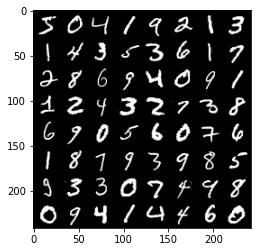

In [12]:
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'output/real')

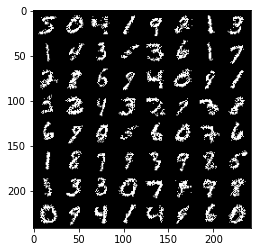

In [13]:
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'output/fake')

In [16]:
images = torch.rand((64, 784))

In [20]:
v, v_gibbs = model(images.view(-1, 784))

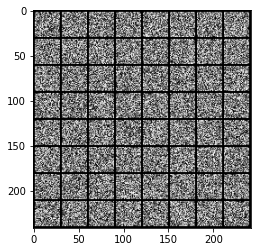

In [21]:
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'output/real')

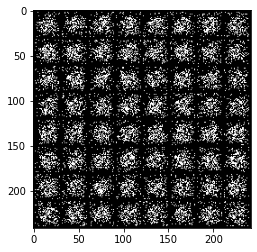

In [22]:
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'output/fake')